# YOFO - You Only Fisheye Once

Pipeline for Localize fisheye image using global descriptor

In [1]:
# Check if we have NVIDIA Driver installed !
!nvidia-smi

Wed Jun  5 20:35:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:41:00.0 Off |                  N/A |
|  0%   56C    P8             48W /  420W |    5872MiB /  24576MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import Stuff

In [2]:
# Imports
# Date Time
from dateutil import tz
from datetime import datetime

# Libraries
import sys
import os
import copy
import json
import numpy as np
import shutil
import PIL

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, metrics

# PYTORCH !
import torch
import torchinfo
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Visualization
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# Path for Import Internal Modules
sys.path.append("/workspace/fisheye-vpr")


2024-06-05 20:35:17.903707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 20:35:18.621429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Fix Seed for Regeneration

In [3]:
## Fix Seed for Regeneration
torch.manual_seed(999)

---

### Import Model

In [4]:
# Main Model
from models.vpr_model import VPRModel

# Feature Extractor
from models.encoders.resnet18 import Resnet18Encoder
from models.encoders.vgg16 import VGG16Encoder

# Clustering
from models.clustering.netvlad import NetVLAD

# Loss
from models.loss_function.HardTripletLoss import HardTripletLoss

# Trainer
from util.train import Trainer

### Dataset Selection

In [5]:
# from dataloaders.isl2_3places_fisheye import ISL2_3Places_Fisheye_Dataset
# dataset = ISL2_3Places_Fisheye_Dataset()

In [6]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

### Exploring Dataset

In [7]:
import matplotlib.pyplot as plt

In [8]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type))
    BSIZE = 8
    figsize=(BSIZE, BSIZE)
    # loop over the batch size
    for i in range(0, BSIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

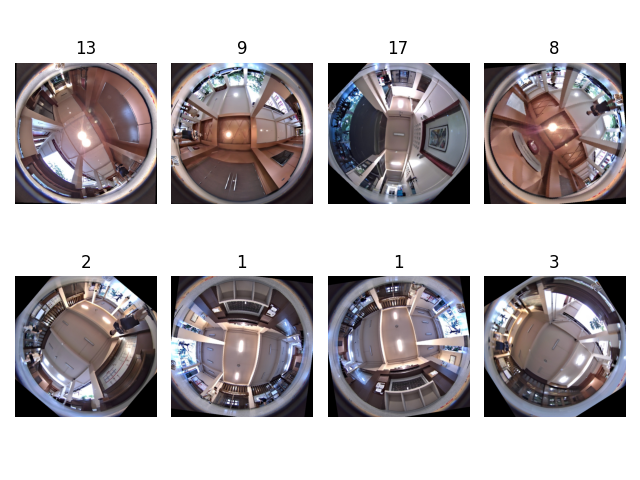

In [9]:
# Display the output
train_batch = next(iter(dataset.train_dataloader))
train_class = dataset.dataset.classes
visualize_batch(train_batch, train_class, "train")


In [10]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

### Model Assembling

In [11]:
netvlad_config = {
    "num_clusters": 32,
    "desc_dim": 512,            # Up to the Feature Extraction Module
    "alpha": 100.0,             # 100.0
    "normalize_input": True,
}
model = VPRModel(
    feature_extractor=VGG16Encoder(fine_tuning=True),
    clustering=NetVLAD(**netvlad_config)
)
model = model.to("cuda")

[VGG16] Output Dim Siafafafze: 512
NetVLAD Module initialized !
 - self.num_clusters : 32
 - self.dim : 512
 - self.alpha : 100.0
 - self.normalize_input : True


In [12]:
torchinfo.summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
VPRModel                                 [1, 16384]                --
├─VGG16Encoder: 1-1                      [1, 512, 16, 16]          --
│    └─Sequential: 2-1                   [1, 512, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]    

### Criterion (Loss Function)

In [13]:
criterion = HardTripletLoss(margin=0.01, hardest=True)

---

### Trainer Setup

In [14]:
# Configuration
config = {
    "run_name": "default",
    "start_time": "",
    "training_epoch": 50,           # EPOCH COUNT
    "enable_tensorboard": True,      # TENSORBOARD
}

In [15]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    weight_decay=0.001,
    momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)

In [16]:
trainer = Trainer(
    dataset,
    model,
    criterion,
    optimizer,
    scheduler,
    config=config,
)

Run Name : vgg16finetuned_NetVLAD32_Eng3_Floor1_2Sec_18Classes_06-Jun-2024_03-35-27
Tensorboard Enabled : True
Log Path : /workspace/results/20240606/vgg16finetuned_NetVLAD32_Eng3_Floor1_2Sec_18Classes_06-Jun-2024_03-35-27


### Training Here !

In [17]:
trainer.train()

Model Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

==> Epoch 0 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 0 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 1 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 1 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 2 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 2 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 3 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 3 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 4 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 4 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 5 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 5 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 6 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 6 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 7 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 7 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 8 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 8 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 9 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 9 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 10 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 10 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 11 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 11 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 12 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 12 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 13 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 13 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 14 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 14 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 15 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 15 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 16 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 16 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 17 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 17 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 18 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 18 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 19 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 19 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 20 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 20 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 21 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 21 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 22 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 22 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 23 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 23 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 24 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 24 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 25 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 25 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 26 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 26 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 27 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 27 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 28 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 28 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 29 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 29 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 30 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 30 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 31 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 31 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 32 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 32 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 33 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 33 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 34 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 34 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 35 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 35 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 36 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 36 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 37 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 37 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 38 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 38 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 39 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 39 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 40 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 40 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 41 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 41 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 42 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 42 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 43 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 43 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 44 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 44 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 45 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 45 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 46 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 46 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 47 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 47 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 48 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 48 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

==> Epoch 49 Training:   0%|          | 0/28 [00:00<?, ? batch/s]

==> Epoch 49 Validating:   0%|          | 0/3 [00:00<?, ?batch/s]

Training Completed !


In [18]:
# Training Details
training_log = {
    "netvlad_config": netvlad_config,
    **config,
}
training_log

{'netvlad_config': {'num_clusters': 32,
  'desc_dim': 512,
  'alpha': 100.0,
  'normalize_input': True},
 'run_name': 'vgg16finetuned_NetVLAD32_Eng3_Floor1_2Sec_18Classes_06-Jun-2024_03-35-27',
 'start_time': '06-Jun-2024_03-35-27',
 'training_epoch': 50,
 'enable_tensorboard': True,
 'epoch_train_loss': array([0.06867729, 0.07050871, 0.04998122, 0.06154134, 0.06779377,
        0.05700975, 0.0590734 , 0.07551891, 0.06123098, 0.05598017,
        0.07056006, 0.06885593, 0.05043111, 0.06773231, 0.06744488,
        0.07899807, 0.06054403, 0.06125095, 0.04297393, 0.07151653,
        0.08058958, 0.05718006, 0.0633305 , 0.06916342, 0.07917022,
        0.08060514, 0.05610275, 0.05552126, 0.06737094, 0.05988299,
        0.05322013, 0.07265495, 0.04821803, 0.05051786, 0.06060318,
        0.05512921, 0.06420899, 0.07263238, 0.06454796, 0.07756185,
        0.05730716, 0.06034259, 0.06827783, 0.06381233, 0.06062935,
        0.08590138, 0.05960295, 0.06067306, 0.0602771 , 0.0516269 ]),
 'epoch_val_l

---

### Global Descriptor Testing

In [19]:
model_path = training_log["best_model_train_path"]
model.load_state_dict(torch.load(model_path))
model.to(torch.device("cuda"))
model.eval()

VPRModel(
  (feature_extractor): VGG16Encoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpl

In [20]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

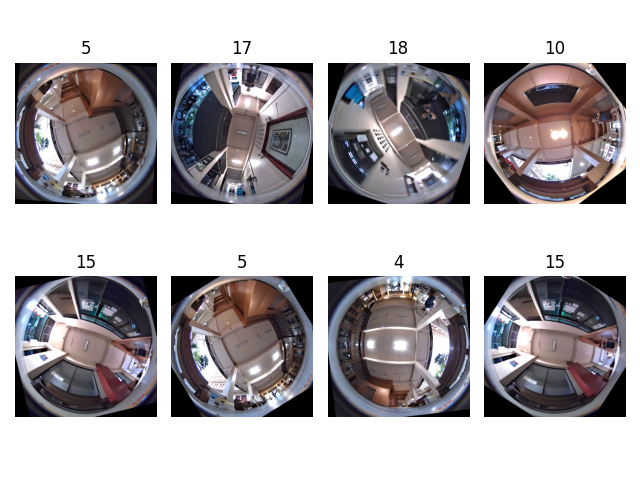

In [21]:
# Load the Data
test_dataloader = dataset.test_dataloader
# Display the output
test_batch = next(iter(dataset.train_dataloader))
test_class = dataset.dataset.classes
visualize_batch(test_batch, test_class, "test")

In [22]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

In [23]:
# Feed the image to model
test_batch, test_label = next(iter(dataset.train_dataloader))
test_batch = test_batch.to(torch.device("cuda"))
test_batch.is_cuda

True

In [24]:
predictions = model(test_batch)
print(predictions.shape)

torch.Size([8, 16384])


### Measure the closeness


In [25]:
test_label

tensor([ 3, 13,  0,  2, 15,  7,  5,  2])

In [26]:
pred = predictions.detach().cpu()
pred.shape

torch.Size([8, 16384])

In [27]:
from util.util import _pairwise_distance

In [28]:
distances = _pairwise_distance(pred)
distances.numpy()

array([[0.        , 0.4870419 , 0.49359524, 0.0920653 , 0.4767368 ,
        0.09350809, 0.5833825 , 0.47729337],
       [0.4870419 , 0.        , 0.70403856, 0.5427955 , 0.10829612,
        0.5434339 , 0.37460896, 0.1086264 ],
       [0.49359524, 0.70403856, 0.        , 0.48696908, 0.6978641 ,
        0.4868043 , 0.59030193, 0.69846   ],
       [0.0920653 , 0.5427955 , 0.48696908, 0.        , 0.5335598 ,
        0.03185263, 0.6278751 , 0.534315  ],
       [0.4767368 , 0.10829612, 0.6978641 , 0.5335598 , 0.        ,
        0.53444654, 0.36093184, 0.0333643 ],
       [0.09350809, 0.5434339 , 0.4868043 , 0.03185263, 0.53444654,
        0.        , 0.6284763 , 0.5350784 ],
       [0.5833825 , 0.37460896, 0.59030193, 0.6278751 , 0.36093184,
        0.6284763 , 0.        , 0.36055198],
       [0.47729337, 0.1086264 , 0.69846   , 0.534315  , 0.0333643 ,
        0.5350784 , 0.36055198, 0.        ]], dtype=float32)

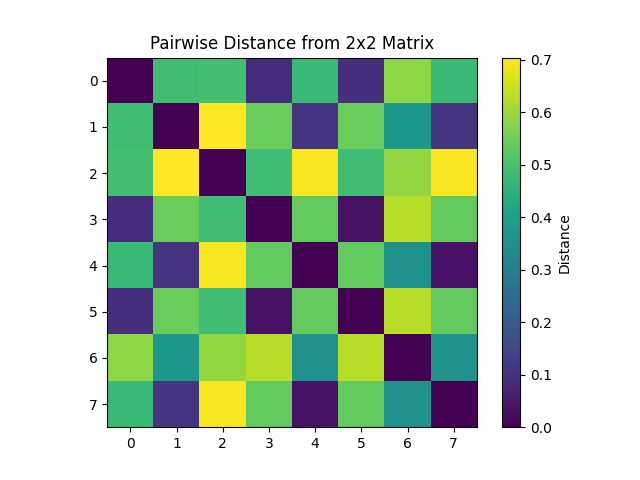

In [29]:
# Visualize the Pairwise Distances 
import matplotlib.pyplot as plt
# Visualize the pairwise distances
plt.figure()
plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Pairwise Distance from 2x2 Matrix')
plt.grid(False)
plt.show()

---

In [30]:
def class_visualize(class_idx_list):
    dataset = ENG3_Floor1_Fisheye_Dataset()
    # Extract the Same class image
    same_class_dataloader = dataset.get_same_class_data(class_idx_list)
    # Feed the image to model
    same_class_batch, same_class_label = next(iter(same_class_dataloader))
    same_class_batch = same_class_batch.to(torch.device("cuda"))
    predictions = model(same_class_batch)
    pred = predictions.detach().cpu()
    distances = _pairwise_distance(pred).numpy()
    # Visualize the pairwise distances
    plt.figure()
    plt.imshow(distances, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Distance')
    plt.title('Same Class Pairwise Distance for class {}'.format(class_idx_list))
    plt.grid(False)
    plt.show()

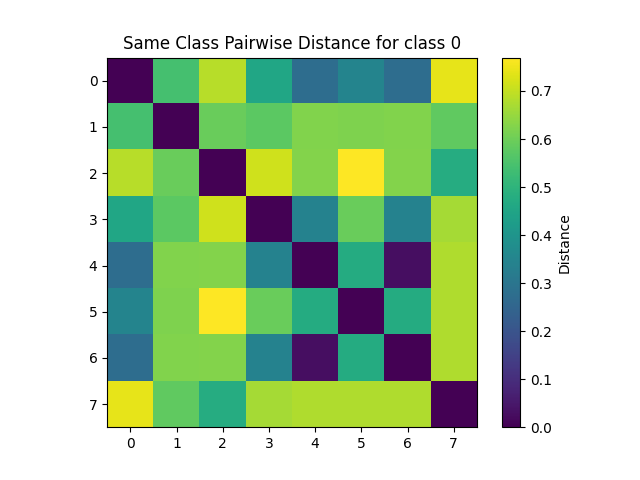

In [31]:
class_visualize(0)

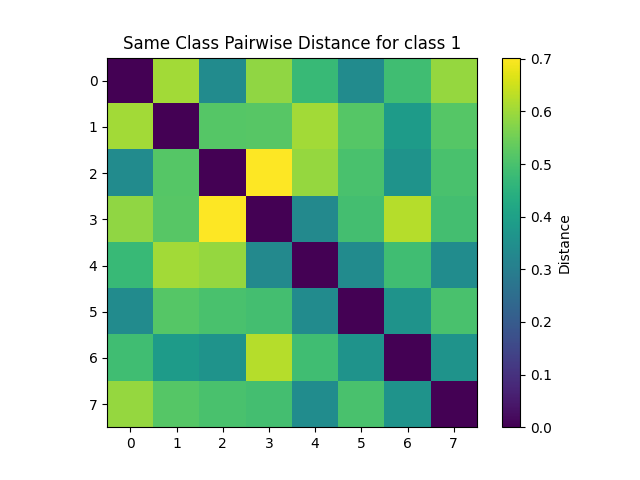

In [32]:
class_visualize(1)

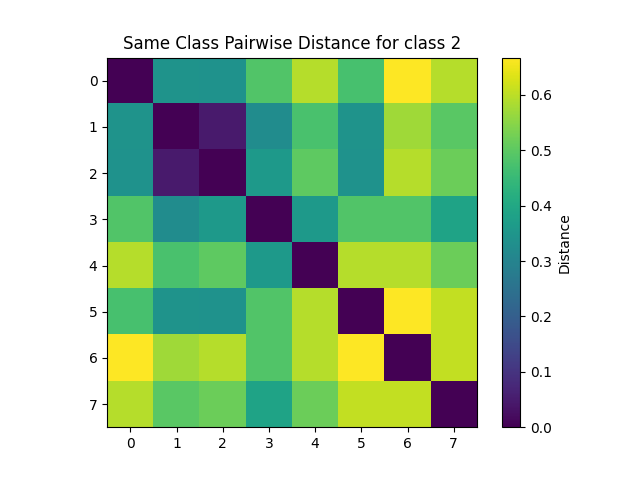

In [33]:
class_visualize(2)

## Visual Place Recognition Part